Copyright 2020 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [3]:
import collections
import functools
import itertools
import os
from typing import Callable, List, Mapping, Sequence, Tuple

from matplotlib import pyplot as plt
import model_util
import numpy as np
import pandas as pd
import pwlf
from pwlfit import fitter
from pwlfit import pwlcurve
from scipy import stats
from sklearn import datasets
from sklearn import metrics
from matplotlib import ticker 

plt.style.use('seaborn-ticks')
plt.rcParams.update({'font.size': 18})


def fit_pwlfit(xs: Sequence[float], ys: Sequence[float], 
               num_segments: int = 3, mono: bool = False):
    """Fits a PWLCurve using pwlfit."""
    return fitter.fit_pwl(xs, ys, num_segments=num_segments, mono=mono).round_to_sig_figs(4)


def fit_pwlf(xs: Sequence[float], ys: Sequence[float], 
             num_segments: int = 3, num_samples: int = 1000) -> pwlcurve.PWLCurve:
    """Fits a PWLCurve using pwlf."""
    mask = model_util.approx_sample(len(xs), num_samples)
    my_pwlf = pwlf.PiecewiseLinFit(xs[mask], ys[mask])
    knot_xs = my_pwlf.fit(num_segments, seed=5)
    knot_ys = my_pwlf.predict(knot_xs)
    return pwlcurve.PWLCurve(list(zip(knot_xs, knot_ys))).round_to_sig_figs(4)


def make_models(train_df: pd.DataFrame, 
                continuous_targets: Mapping[str, str],
                discrete_targets: Mapping[str, str]) -> Tuple[List[model_util.Model], pd.DataFrame]:
    """Make models to analyze with timing data."""
    models = [
        model_util.ColumnModel('interacting_trees'),
        model_util.ColumnModel('gam_trees')
    ]
    models += [model_util.ColumnModel('sgd_num_segments_%d' % i) 
                   for i in list(range(1, 11)) + [15, 20]]
    times = []
    for (i, mono) in itertools.product(range(1,6), (False, True)):
        curve_fitter = functools.partial(fit_pwlfit, num_segments=i, mono=mono)
        pwlfit_model, plwfit_times = model_util.fit_additive_model(
            train_df, continuous_targets, discrete_targets, curve_fitter,
            'pwlfit; num_segments=%d mono=%s' % (i, mono))
        models.append(pwlfit_model)
        times.append(plwfit_times)
    for i in range(2, 6):
        curve_fitter = functools.partial(fit_pwlf, num_segments=i)
        pwlf_model, pwlf_times = model_util.fit_additive_model(
            train_df, continuous_targets, discrete_targets, curve_fitter,
            'pwlf; num_segments=%d' % i)
        models.append(pwlf_model)
        times.append(pwlf_times)
    timing_df = pd.DataFrame(times).transpose()
    timing_df.columns = [m.name for m in models[14:]]
    return models, timing_df


def make_ndcg_df(test_df: pd.DataFrame, models: List[model_util.Model]) -> pd.DataFrame:
    """Computes NDCG values on all queries."""
    ndcg_vals = collections.defaultdict(list)
    test_df = test_df.copy()
    group_by = test_df.groupby('qid')
    max_query_len = max(group_by.size())
    num_queries = len(group_by)
    # pad with extra docs so we can use matrix math for speed
    y_true = np.full((num_queries, max_query_len), -float('inf'))
    y_score = y_true.copy()
    y_size = []
    for i, (_, df) in enumerate(group_by):
        query_len = len(df.label.values)
        y_size.append(query_len)
        y_true[i, :query_len] = df.label.values
    y_size = np.array(y_size)
    for m in models:
        test_df['tmp_model'] = m.eval(test_df)
        group_by = test_df.groupby('qid')
        for i, (_, df) in enumerate(group_by):
            query_len = len(df.label.values)
            y_score[i, :query_len] = df.tmp_model.values
        ndcg_vals[m.name] = model_util.ndcg_metric(y_true, y_score, k=5, y_size=y_size)
    df = pd.DataFrame(ndcg_vals)
    return df


def make_rmse_df(test_df: pd.DataFrame, tree_model: model_util.AdditiveModel, 
                 curve_models: List[model_util.AdditiveModel]) -> pd.DataFrame:
    """Compute RMSE vs source on each submodel."""
    rmses = collections.defaultdict(list)
    for name in tree_model.feature_names:
        feature_name = name.replace('gam_trees_', '')
        for model in curve_models:
            rmses[feature_name].append(
                metrics.mean_squared_error(tree_model.get_submodel(name).eval(test_df),
                                           model.get_submodel(feature_name).eval(test_df),
                                           squared=False))
    df = pd.DataFrame(rmses).transpose()
    df.columns = [m.name for m in curve_models]
    return df


def _load_dataset(name: str, input_dir: str):
    X, y, qid = datasets.load_svmlight_file(os.path.join(input_dir, '%s.txt' % name), query_id=True)
    raw_df = pd.DataFrame(X.todense(), columns=['feature_%04d' % i for i in range(1, 137)])
    raw_df['label'] = y
    raw_df['qid'] = qid
    scores_df = pd.read_parquet(os.path.join(input_dir, '%s.parquet' % name))
    return pd.concat([raw_df, scores_df], axis=1)


def read_data(input_dir: str):
    """Reads data and returns train_df, test_df."""
    return _load_dataset('train', input_dir), _load_dataset('test', input_dir)


def compute_ci_width(col):
    mean = col.mean()
    _, upper = stats.norm.interval(0.95, loc=mean, scale=(col.std() / np.sqrt(len(col))))
    return upper - mean

In [5]:
INPUT_DIR = '<YOUR_INPUT_DIR>'

In [6]:
train_df, test_df = read_data(INPUT_DIR)
CONTINUOUS_FEATURES = ['feature_%04d' % i for i in range(1, 137)]

In [ ]:
models, timing_df = make_models(train_df, {name: 'gam_trees_%s' % name for name in CONTINUOUS_FEATURES}, {})

In [8]:
timing_df

,pwlfit; num_segments=1 mono=False,pwlfit; num_segments=1 mono=True,pwlfit; num_segments=2 mono=False,pwlfit; num_segments=2 mono=True,pwlfit; num_segments=3 mono=False,pwlfit; num_segments=3 mono=True,pwlfit; num_segments=4 mono=False,pwlfit; num_segments=4 mono=True,pwlfit; num_segments=5 mono=False,pwlfit; num_segments=5 mono=True,pwlf; num_segments=2,pwlf; num_segments=3,pwlf; num_segments=4,pwlf; num_segments=5
f_feature_0001,0.131719,0.094269,0.092254,0.097969,0.096374,0.104387,0.101285,0.110634,0.101740,0.116682,0.055071,0.138112,0.311945,15.878410
f_feature_0002,0.096748,0.086195,0.085800,0.088782,0.085976,0.090392,0.086175,0.091519,0.086506,0.090093,0.051579,0.084877,10.710438,15.544661
f_feature_0003,0.105443,0.094572,0.092856,0.098051,0.093440,0.097798,0.096427,0.105331,0.098321,0.111127,0.033401,0.120845,0.426558,16.038857
f_feature_0004,0.116267,0.092858,0.092038,0.097753,0.093677,0.102060,0.094860,0.107413,0.095398,0.111614,0.050872,0.065946,0.150248,0.611357
f_feature_0005,0.091577,0.094435,0.093766,0.102738,0.096416,0.109439,0.097743,0.127802,0.100226,0.123996,0.055663,0.114431,0.220603,0.478676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f_feature_0132,0.131471,0.143275,0.136976,0.159769,0.198152,0.321183,0.200036,0.290909,0.234473,0.443549,0.030387,0.132251,0.206415,0.525339
f_feature_0133,0.131893,0.142443,0.140296,0.159124,0.157868,0.199893,0.209430,0.316223,0.240716,0.434059,0.040973,0.122762,0.425911,0.603218
f_feature_0134,0.090418,0.098376,0.116488,0.150277,0.137280,0.195419,0.137263,0.187890,0.185008,0.296902,0.059819,0.224149,0.580116,1.594383
f_feature_0135,0.113285,0.129544,0.155433,0.226842,0.136880,0.176839,0.150294,0.208878,0.249549,0.475796,0.072639,0.360785,0.715229,1.230279


In [9]:
pd.concat([timing_df.mean(), timing_df.apply(compute_ci_width)], axis=1)

,0,1
pwlfit; num_segments=1 mono=False,0.139780,0.007287
pwlfit; num_segments=1 mono=True,0.157612,0.008648
pwlfit; num_segments=2 mono=False,0.154691,0.008218
pwlfit; num_segments=2 mono=True,0.214404,0.013711
pwlfit; num_segments=3 mono=False,0.178922,0.010111
pwlfit; num_segments=3 mono=True,0.285264,0.020469
pwlfit; num_segments=4 mono=False,0.197723,0.011393
pwlfit; num_segments=4 mono=True,0.353623,0.027997
pwlfit; num_segments=5 mono=False,0.229115,0.014208
pwlfit; num_segments=5 mono=True,0.448659,0.037928


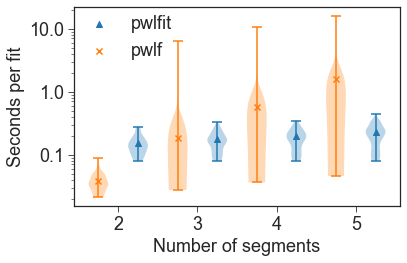

In [10]:
num_segments = timing_df.columns.str.extract(r'num_segments=(\d+)', expand=False).astype(int)
column_str = timing_df.columns.str
plt.violinplot(
    list(timing_df[
        timing_df.columns[column_str.match(r'pwlfit;.*mono=False') & (num_segments > 1)]].transpose().values), 
    positions=np.arange(2, 6) + 0.25, widths=[0.25] * 4, points=136)
plt.violinplot(
    list(timing_df[timing_df.columns[column_str.match(r'pwlf;')]].transpose().values), 
    positions=np.arange(2, 6) - 0.25, widths=[0.25] * 4, points=136)

mean = timing_df.mean()
num_segments = mean.index.str.extract(r'num_segments=(\d+)', expand=False).astype(int)
index_str = mean.index.str
plt.scatter(num_segments[index_str.match(r'pwlfit;.*mono=False') & (num_segments > 1)] + 0.25, 
            mean[index_str.match(r'pwlfit;.*mono=False') & (num_segments > 1)], 
            label='pwlfit', marker='^')
plt.scatter(num_segments[index_str.match(r'pwlf;')] - 0.25, 
            mean[index_str.match(r'pwlf;')], label='pwlf', marker='x')

plt.gca().set_xlabel('Number of segments')
plt.gca().set_ylabel('Seconds per fit')
plt.gca().set_yscale('log')
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc=(0,0.7))
plt.tight_layout()

In [11]:
tree_model = model_util.AdditiveModel(
    [model_util.ColumnModel('gam_trees_%s' % name) for name in CONTINUOUS_FEATURES],
    'tree_model')
rmse_df = make_rmse_df(test_df, tree_model, [m for m in models if 'pwl' in m.name])

In [12]:
rmse_df

,pwlfit; num_segments=1 mono=False,pwlfit; num_segments=1 mono=True,pwlfit; num_segments=2 mono=False,pwlfit; num_segments=2 mono=True,pwlfit; num_segments=3 mono=False,pwlfit; num_segments=3 mono=True,pwlfit; num_segments=4 mono=False,pwlfit; num_segments=4 mono=True,pwlfit; num_segments=5 mono=False,pwlfit; num_segments=5 mono=True,pwlf; num_segments=2,pwlf; num_segments=3,pwlf; num_segments=4,pwlf; num_segments=5
feature_0001,0.028732,0.028732,0.021165,0.028310,0.015224,0.028310,0.011924,0.028310,0.005906,0.028310,0.019095,0.013979,0.006274,0.014889
feature_0002,0.002810,0.002810,0.002303,0.002303,0.001914,0.001823,0.001297,0.001765,0.001186,0.001765,0.002942,0.002172,0.002164,0.002164
feature_0003,0.047897,0.047897,0.036573,0.036573,0.026067,0.026067,0.013204,0.013204,0.010205,0.010205,0.066532,0.014435,0.010252,0.002349
feature_0004,0.012409,0.012409,0.008014,0.011930,0.004805,0.011600,0.003506,0.011582,0.002591,0.011458,0.012929,0.011753,0.004806,0.028742
feature_0005,0.052637,0.052637,0.032545,0.049161,0.024294,0.049098,0.015375,0.048057,0.015173,0.048636,0.070441,0.041356,0.016429,0.009999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feature_0132,0.208841,0.208841,0.188373,0.188373,0.179505,0.179505,0.170948,0.170948,0.163729,0.165175,0.194056,0.178095,0.153197,0.169635
feature_0133,0.296258,0.296258,0.254959,0.254959,0.220631,0.220631,0.204189,0.204457,0.191175,0.191175,0.297197,0.244810,0.208089,0.210802
feature_0134,0.184026,0.184026,0.150384,0.150384,0.094752,0.094752,0.083227,0.083227,0.062954,0.062954,0.421166,0.244478,0.123829,0.096273
feature_0135,0.071840,0.071840,0.060281,0.060281,0.057774,0.057774,0.056571,0.056571,0.053046,0.053046,0.218024,0.098073,0.067919,0.080075


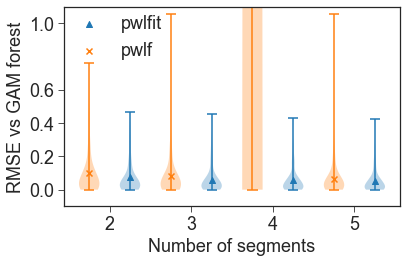

In [13]:
num_segments = rmse_df.columns.str.extract(r'num_segments=(\d+)', expand=False).astype(int)
column_str = rmse_df.columns.str
plt.violinplot(
    list(rmse_df[
        rmse_df.columns[column_str.match(r'pwlfit;.*mono=False') & (num_segments > 1)]].transpose().values), 
    positions=np.arange(2, 6) + 0.25, widths=[0.25] * 4, points=136)
plt.violinplot(
    list(rmse_df[rmse_df.columns[column_str.match(r'pwlf;')]].transpose().values), 
    positions=np.arange(2, 6) - 0.25, widths=[0.25] * 4, points=136)

mean = rmse_df.mean()
num_segments = mean.index.str.extract(r'num_segments=(\d+)', expand=False).astype(int)
index_str = mean.index.str
plt.scatter(num_segments[index_str.match(r'pwlfit;.*mono=False') & (num_segments > 1)] + 0.25, 
            mean[index_str.match(r'pwlfit;.*mono=False') & (num_segments > 1)], 
            label='pwlfit', marker='^')
plt.scatter(num_segments[index_str.match(r'pwlf;')] - 0.25, 
            mean[index_str.match(r'pwlf;')], label='pwlf', marker='x')

plt.gca().set_xlabel('Number of segments')
plt.gca().set_ylabel('RMSE vs GAM forest')
plt.gca().set_yticks([0, 0.2, 0.4, 0.6, 1.])
plt.gca().set_ylim(-0.1, 1.1)
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.legend(loc=(0, 0.7))
plt.tight_layout()

In [ ]:
ndcg_df = make_ndcg_df(test_df, models)

In [15]:
ndcg_df

,interacting_trees,gam_trees,sgd_num_segments_1,sgd_num_segments_2,sgd_num_segments_3,sgd_num_segments_4,sgd_num_segments_5,sgd_num_segments_6,sgd_num_segments_7,sgd_num_segments_8,...,pwlfit; num_segments=3 mono=False,pwlfit; num_segments=3 mono=True,pwlfit; num_segments=4 mono=False,pwlfit; num_segments=4 mono=True,pwlfit; num_segments=5 mono=False,pwlfit; num_segments=5 mono=True,pwlf; num_segments=2,pwlf; num_segments=3,pwlf; num_segments=4,pwlf; num_segments=5
0,0.882680,0.889590,0.199915,0.350536,0.389020,0.612447,0.577050,0.545502,0.446115,0.492725,...,0.859092,0.716810,0.859092,0.725008,0.859092,0.725008,0.716810,0.787731,0.889590,0.859092
1,0.430424,0.474256,0.182171,0.223349,0.161746,0.168008,0.332422,0.188433,0.168008,0.317871,...,0.591955,0.591955,0.591955,0.469405,0.469405,0.469405,0.552973,0.474256,0.303936,0.426587
2,0.655671,0.739737,0.695215,0.770727,0.785451,0.637277,0.683693,0.548045,0.623558,0.674672,...,0.689396,0.705661,0.689396,0.655320,0.655320,0.705661,0.835793,0.705661,0.689396,0.689396
3,0.688604,0.688604,0.610755,0.541252,0.307705,0.440669,0.571830,0.588021,0.541252,0.588021,...,0.688604,0.688604,0.688604,0.688604,0.688604,0.688604,0.688604,0.688604,0.532906,0.590369
4,0.485229,0.699215,0.853932,0.553146,0.868795,0.853932,0.853932,0.722727,0.722727,0.684352,...,0.699215,0.684352,0.699215,0.684352,0.699215,0.684352,0.699215,0.699215,0.699215,0.830420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6301,0.419117,0.685150,0.599659,0.444724,0.577156,0.650873,0.650873,0.650873,0.665875,0.650873,...,0.662739,0.464091,0.464091,0.464091,0.464091,0.464091,0.452225,0.486501,0.662739,0.464091
6302,0.672822,0.649116,0.685729,0.377666,0.553540,0.544359,0.544359,0.544359,0.568065,0.568065,...,0.513015,0.513015,0.513015,0.513015,0.513015,0.513015,0.544359,0.634591,0.554971,0.513015
6303,0.754228,0.574104,0.378907,0.571253,0.539491,0.547041,0.574104,0.574104,0.608181,0.580158,...,0.571253,0.571253,0.571253,0.571253,0.571253,0.539679,0.539679,0.621595,0.571253,0.571253
6304,0.500021,0.296590,0.263663,0.449939,0.377208,0.394825,0.327769,0.394825,0.388001,0.394825,...,0.316976,0.327769,0.316976,0.463403,0.310152,0.403171,0.377208,0.305999,0.310152,0.316976


In [16]:
pd.concat([ndcg_df.mean(), ndcg_df.apply(compute_ci_width)], axis=1)

,0,1
interacting_trees,0.485273,0.006043
gam_trees,0.441584,0.006026
sgd_num_segments_1,0.352051,0.005810
sgd_num_segments_2,0.381980,0.006023
sgd_num_segments_3,0.392585,0.006124
sgd_num_segments_4,0.400729,0.006166
sgd_num_segments_5,0.404012,0.006139
sgd_num_segments_6,0.406225,0.006150
sgd_num_segments_7,0.407725,0.006113
sgd_num_segments_8,0.410191,0.006105


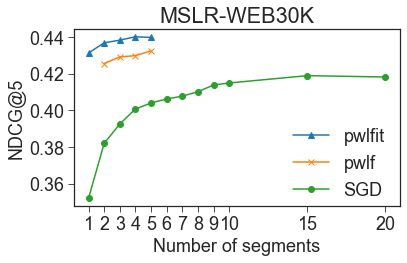

In [17]:
mean = ndcg_df.mean()
num_segments = mean.index.str.extract(r'segments(?:=|_)(\d+)', expand=False)
index_str = mean.index.str
plt.plot(num_segments[index_str.match(r'pwlfit;.*mono=False')].astype(int), 
         mean[index_str.match(r'pwlfit;.*mono=False')], marker='^', label='pwlfit')
plt.plot(num_segments[index_str.match('pwlf;')].astype(int), 
         mean[index_str.match('pwlf;')], marker='x', label='pwlf')
plt.plot(num_segments[index_str.match('sgd_')].astype(int), 
         mean[index_str.match('sgd_')], marker='o', label='SGD')
plt.gca().set_xticks(num_segments.dropna().drop_duplicates().astype(int))
plt.gca().set_xlabel('Number of segments')
plt.gca().set_ylabel('NDCG@5')
plt.title('MSLR-WEB30K')
plt.gca().set_yticks(np.arange(0.36, 0.44, 0.02))
plt.legend(loc=(0.65, 0))
plt.tight_layout()

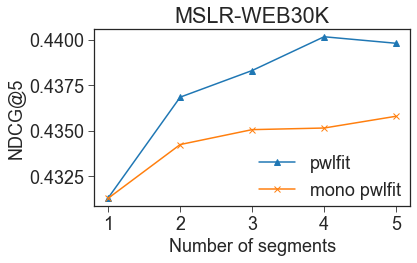

In [18]:
mean = ndcg_df.mean()
num_segments = mean.index.str.extract(r'num_segments=(\d+)', expand=False)
index_str = mean.index.str
plt.plot(num_segments[index_str.match(r'pwlfit;.*mono=False')].astype(int), 
         mean[index_str.match(r'pwlfit;.*mono=False')], marker='^', label='pwlfit')
plt.plot(num_segments[index_str.match(r'pwlfit;.*mono=True')].astype(int), 
         mean[index_str.match(r'pwlfit;.*mono=True')], marker='x', label='mono pwlfit')
plt.gca().set_xlabel('Number of segments')
plt.gca().set_ylabel('NDCG@5')
plt.title('MSLR-WEB30K')
plt.legend(loc=(0.5, 0))
plt.tight_layout()